In [2]:
#############################################################################
############################# Assignment 2 ##################################
######################### Author: Shawn Liu #################################
#############################################################################

In [3]:
import datetime
import time
import numpy as np
import pandas as pd
from packaging import version
from collections import Counter

from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import mean_squared_error as MSE
from sklearn.model_selection import train_test_split
from sklearn.manifold import TSNE

import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import models, layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, BatchNormalization, Dropout, Flatten, Input, Dense
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.preprocessing import image
from tensorflow.keras.utils import to_categorical

In [4]:
%matplotlib inline
np.set_printoptions(precision=3, suppress=True)

In [5]:
print("This notebook requires TensorFlow 2.0 or above")
print("TensorFlow version: ", tf.__version__)
assert version.parse(tf.__version__).release[0] >=2

This notebook requires TensorFlow 2.0 or above
TensorFlow version:  2.7.0


In [6]:
print("Keras version: ", keras.__version__)

Keras version:  2.7.0


In [7]:
#mount to Google Drive

from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [8]:
path = '/content/gdrive/MyDrive/458_AI/Assignment2/'

In [9]:
# define functions for model performance evaluation
def print_validation_report(y_test, predictions):
    print("Classification Report")
    print(classification_report(y_test, predictions))
    print('Accuracy Score: {}'.format(accuracy_score(y_test, predictions)))
    print('Root Mean Square Error: {}'.format(np.sqrt(MSE(y_test, predictions)))) 

In [10]:
def plot_confusion_matrix(y_true, y_pred):
    mtx = confusion_matrix(y_true, y_pred)
    fig, ax = plt.subplots(figsize=(8,8))
    sns.heatmap(mtx, annot=True, fmt='d', linewidths=.75,  cbar=False, ax=ax,cmap='Blues',linecolor='white')
    #  square=True,
    plt.ylabel('true label')
    plt.xlabel('predicted label')

#**Loading data & EDA**

In [11]:
(x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()

170508288/170498071 [==============================] - 3s 0us/step


In [12]:
print('train_images:\t{}'.format(x_train.shape))
print('train_labels:\t{}'.format(y_train.shape))
print('test_images:\t\t{}'.format(x_test.shape))
print('test_labels:\t\t{}'.format(y_test.shape))

train_images:	(50000, 32, 32, 3)
train_labels:	(50000, 1)
test_images:		(10000, 32, 32, 3)
test_labels:		(10000, 1)


In [13]:
#review labels and distribution of sample
print("First ten labels training dataset:\n {}\n".format(y_train[0:10]))
print("This output the numeric label, need to convert to item description")

First ten labels training dataset:
 [[6]
 [9]
 [9]
 [4]
 [1]
 [1]
 [2]
 [7]
 [8]
 [3]]

This output the numeric label, need to convert to item description


<BarContainer object of 10 artists>

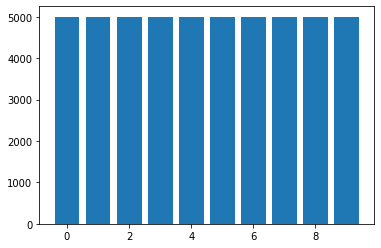

In [14]:
(unique, counts) = np.unique(y_train, return_counts=True)

frequency_trn = np.array((unique, counts))
plt.bar(frequency_trn[0], frequency_trn[1])

In [15]:
#plot some examples

def get_three_classes(x, y):
    def indices_of(class_id):
        indices, _ = np.where(y == float(class_id))
        return indices

    indices = np.concatenate([indices_of(0), indices_of(1), indices_of(2)], axis=0)
    
    x = x[indices]
    y = y[indices]
    
    count = x.shape[0]
    indices = np.random.choice(range(count), count, replace=False)
    
    x = x[indices]
    y = y[indices]
    
    y = tf.keras.utils.to_categorical(y)
    
    return x, y

In [16]:
(train_images, train_labels),(test_images, test_labels)= tf.keras.datasets.cifar10.load_data()

In [17]:
x_preview, y_preview = get_three_classes(train_images, train_labels)
x_preview, y_preview = get_three_classes(test_images, test_labels)

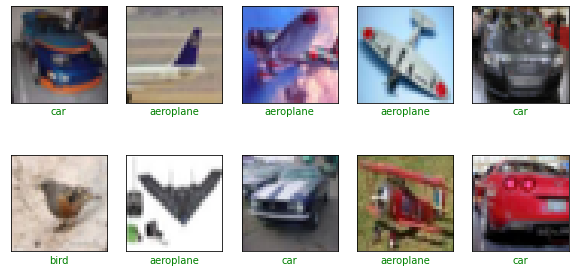

In [18]:
class_names_preview = ['aeroplane', 'car', 'bird']

def show_random_examples(x, y, p):
    indices = np.random.choice(range(x.shape[0]), 10, replace=False)
    
    x = x[indices]
    y = y[indices]
    p = p[indices]
    
    plt.figure(figsize=(10, 5))
    for i in range(10):
        plt.subplot(2, 5, i + 1)
        plt.imshow(x[i])
        plt.xticks([])
        plt.yticks([])
        col = 'green' if np.argmax(y[i]) == np.argmax(p[i]) else 'red'
        plt.xlabel(class_names_preview[np.argmax(p[i])], color=col)
    plt.show()

show_random_examples(x_preview, y_preview, y_preview)

#**Preprocessing Data For Model Development**

In [19]:
class_names = ['airplane'
,'automobile'
,'bird'
,'cat'
,'deer'
,'dog'
,'frog' 
,'horse'
,'ship'
,'truck']

In [20]:
##create validation Dataset

x_train_split, x_valid_split, y_train_split, y_valid_split = train_test_split(x_train
                                                                              ,y_train
                                                                              ,test_size=.1
                                                                              ,random_state=42
                                                                              ,shuffle=True)

In [21]:
#check dataset size and dimension, 10% of training data is hold out for validation purpose
print(x_train_split.shape, x_valid_split.shape, x_test.shape)

(45000, 32, 32, 3) (5000, 32, 32, 3) (10000, 32, 32, 3)


In [22]:
#scale normalize the data
#The images are 28x28 NumPy arrays, with pixel values ranging from 0 to 255
# 1. Each element in each example is a pixel value
# 2. Pixel values range from 0 to 255
# 3. 0 = black
# 4. 255 = white

In [23]:
x_train_norm = x_train_split / 255 
x_valid_norm = x_valid_split / 255
x_test_norm = x_test / 255

In [24]:
#reshape the image for DNN training
width = 32
height = 32
channel = 3

x_train_flat = np.reshape(x_train_norm, (45000, width*height*channel))
x_valid_flat = np.reshape(x_valid_norm, (5000, width*height*channel))
x_test_flat = np.reshape(x_test_norm, (10000, width*height*channel))

In [25]:
print(x_train_flat.shape, x_valid_flat.shape, x_test_flat.shape)

(45000, 3072) (5000, 3072) (10000, 3072)


In [26]:
##initiate list to track performance for each model


train_accuracy = []
val_accuracy = []
test_accuracy = []
recall = []
f1 = []
precision = []
train_time = []

In [27]:
# define function for turning softmax result to class category
def class_output(result):
  pred_list = []
  for i in range(len(result)):
    pred = np.argmax(result[i])
    pred_list.append(pred)
  return np.array(pred_list).reshape((len(result), 1))

In [28]:
# define evaluation metrics tracking function

def score_track(model, x_train, y_train, x_val, y_val, x_test, y_test):
  result_dic = {}

  pred_trn = class_output(model.predict(x_train))
  ac_trn = accuracy_score(y_train, pred_trn)
  result_dic['accuracy_train'] = ac_trn

  pred_val = class_output(model.predict(x_val))
  ac_val = accuracy_score(y_val, pred_val)
  result_dic['accuracy_valid'] = ac_val

  pred_test = class_output(model.predict(x_test))
  ac_test = accuracy_score(y_test, pred_test)
  result_dic['accuracy_test'] = ac_test
  f1_test = f1_score(y_test, pred_test, average = 'macro')
  result_dic['f1_test'] = f1_test
  recall_test = recall_score(y_test, pred_test, average = 'macro')
  result_dic['recall_test'] = recall_test
  precision_test = precision_score(y_test, pred_test, average = 'macro')
  result_dic['precision_test'] = precision_test
  
  return result_dic

#**Experiment 7 - CNN with 6 layers (regularization)**

1. five Conv Layer + Pooling Layers
2. with regularization
3. Without Dropout & Batch_Normalization layer
4. dropout rate changed to 0.2
5. Avergage Pooling

In [33]:
model_deep = models.Sequential()
model_deep.add(layers.Conv2D(filters=128, kernel_size=(3, 3), strides=(1, 1), padding = 'same', activation=tf.nn.relu,input_shape=(32, 32, 3)))
model_deep.add(layers.AveragePooling2D((2, 2),strides=2))
model_deep.add(layers.Dropout(0.2))
model_deep.add(layers.Conv2D(filters=256, kernel_size=(3, 3), strides=(1, 1), padding = 'same', activation=tf.nn.relu))
model_deep.add(layers.AveragePooling2D(pool_size=(2, 2),strides=2))
model_deep.add(layers.Dropout(0.2))
model_deep.add(layers.Conv2D(filters=512, kernel_size=(3, 3), strides=(1, 1), padding = 'same', activation=tf.nn.relu))
model_deep.add(layers.AveragePooling2D(pool_size=(2, 2),strides=2))
model_deep.add(layers.Dropout(0.2))
model_deep.add(layers.Conv2D(filters=1024, kernel_size=(3, 3), strides=(1, 1), padding = 'same', activation=tf.nn.relu))
model_deep.add(layers.AveragePooling2D(pool_size=(2, 2),strides=2))
model_deep.add(layers.Dropout(0.2))
model_deep.add(layers.Conv2D(filters=2048, kernel_size=(3, 3), strides=(1, 1), padding = 'same', activation=tf.nn.relu))
model_deep.add(layers.AveragePooling2D(pool_size=(2, 2),strides=2))
model_deep.add(layers.Dropout(0.2))
model_deep.add(layers.Flatten())
model_deep.add(layers.BatchNormalization())
model_deep.add(layers.Dense(units=384, activation=tf.nn.relu, kernel_regularizer=tf.keras.regularizers.L2(0.001)))
model_deep.add(layers.Dense(units=10, activation=tf.nn.softmax))

In [34]:
#@title
model_deep.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_10 (Conv2D)          (None, 32, 32, 128)       3584      
                                                                 
 average_pooling2d_10 (Avera  (None, 16, 16, 128)      0         
 gePooling2D)                                                    
                                                                 
 dropout_10 (Dropout)        (None, 16, 16, 128)       0         
                                                                 
 conv2d_11 (Conv2D)          (None, 16, 16, 256)       295168    
                                                                 
 average_pooling2d_11 (Avera  (None, 8, 8, 256)        0         
 gePooling2D)                                                    
                                                                 
 dropout_11 (Dropout)        (None, 8, 8, 256)        

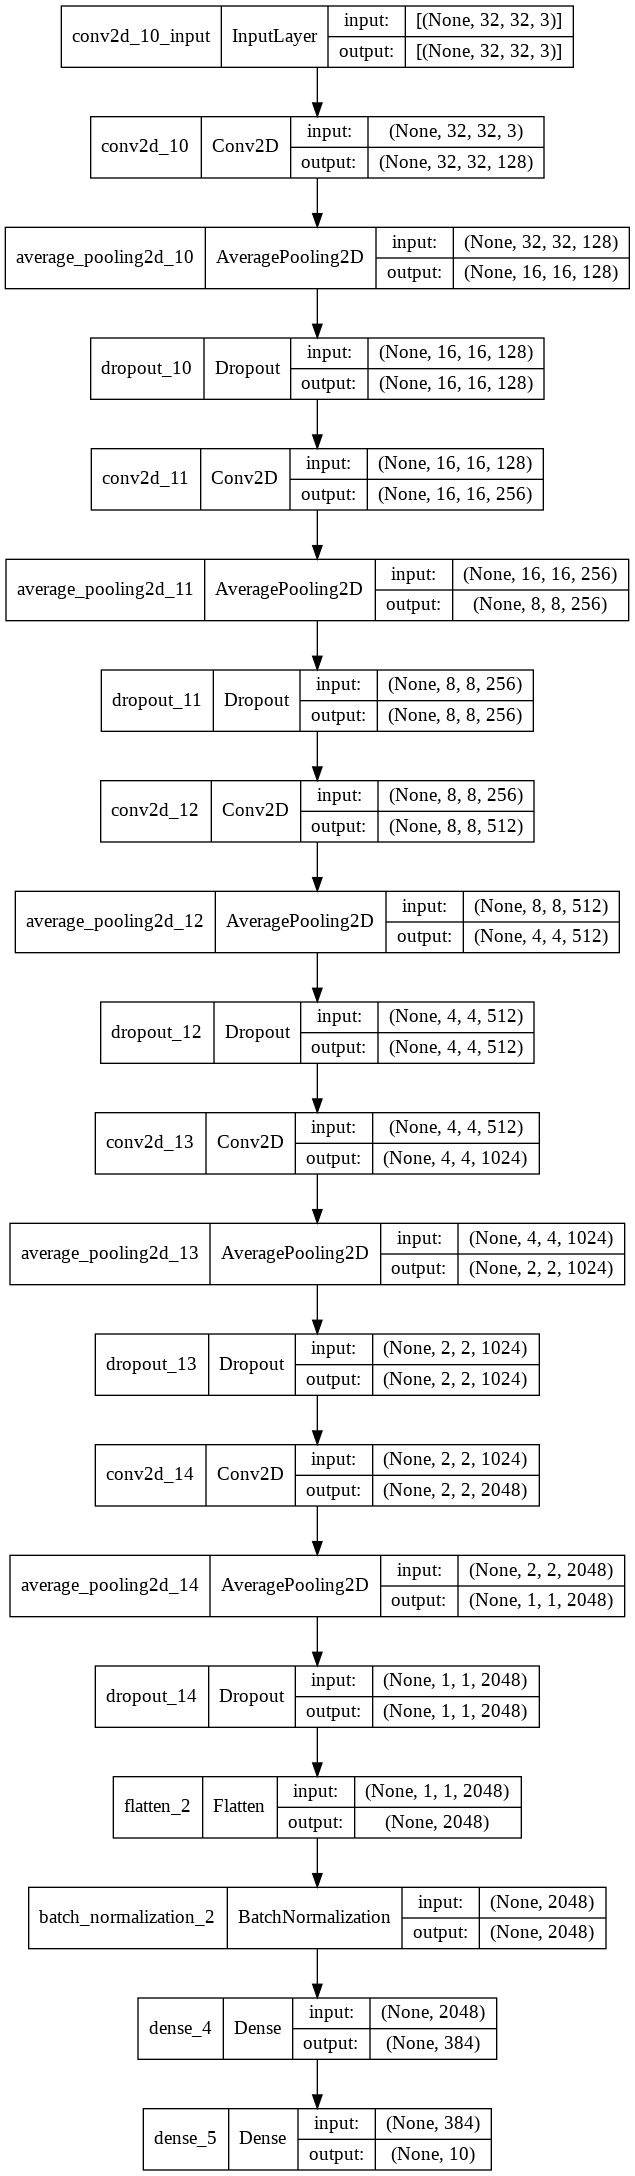

In [35]:
#@title
keras.utils.plot_model(model_deep, "CIFAR10.png", show_shapes=True) 

In [36]:
#@title
model_deep.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

In [37]:
#@title
#training the model

start_time = time.time()

history_deep = model_deep.fit(x_train_norm
                    ,y_train_split
                    ,epochs=100
                    ,batch_size=512
                    ,validation_data=(x_valid_norm, y_valid_split)
                    ,callbacks=[
                    tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3),
                    tf.keras.callbacks.ModelCheckpoint(path +'model_{val_accuracy:.4f}.h5', save_best_only=True,
                                        save_weights_only=False, monitor='val_accuracy')]
)

end_time = time.time() 

Epoch 1/100
88/88 [==============================] - 30s 188ms/step - loss: 2.0328 - accuracy: 0.3683 - val_loss: 2.3530 - val_accuracy: 0.3744
Epoch 2/100
88/88 [==============================] - 11s 123ms/step - loss: 1.4101 - accuracy: 0.5360 - val_loss: 2.1236 - val_accuracy: 0.4980
Epoch 3/100
88/88 [==============================] - 11s 123ms/step - loss: 1.1256 - accuracy: 0.6267 - val_loss: 1.9110 - val_accuracy: 0.5748
Epoch 4/100
88/88 [==============================] - 11s 122ms/step - loss: 0.9628 - accuracy: 0.6779 - val_loss: 1.5823 - val_accuracy: 0.6936
Epoch 5/100
88/88 [==============================] - 11s 124ms/step - loss: 0.8635 - accuracy: 0.7098 - val_loss: 1.2745 - val_accuracy: 0.7064
Epoch 6/100
88/88 [==============================] - 11s 122ms/step - loss: 0.7657 - accuracy: 0.7422 - val_loss: 0.9653 - val_accuracy: 0.7436
Epoch 7/100
88/88 [==============================] - 10s 108ms/step - loss: 0.6980 - accuracy: 0.7631 - val_loss: 0.8247 - val_accuracy:

In [38]:
#@title
#tracking training time
train_time = end_time - start_time

In [39]:
#@title
loss, accuracy = model_deep.evaluate(x_test_norm, y_test)
print('test set accuracy: ', accuracy * 100)

313/313 [==============================] - 4s 10ms/step - loss: 0.7187 - accuracy: 0.8101
test set accuracy:  81.01000189781189


In [40]:
#@title
preds = model_deep.predict(x_test_norm)
print('shape of preds: ', preds.shape)

shape of preds:  (10000, 10)


In [ ]:
#@title
model_deep_score = score_track(model_deep, x_train_norm, y_train_split, x_valid_norm, y_valid_split, x_test_norm, y_test)

model_3_score['train_time'] = train_time

In [ ]:
#@title
history_dict = history_3.history
history_dict.keys()

In [ ]:
#@title
history_df=pd.DataFrame(history_dict)
history_df.tail().round(3)

In [ ]:
#@title
losses = history_3.history['loss']
accs = history_3.history['accuracy']
val_losses = history_3.history['val_loss']
val_accs = history_3.history['val_accuracy']
epochs = len(losses)

In [ ]:
#@title
plt.figure(figsize=(16, 4))
for i, metrics in enumerate(zip([losses, accs], [val_losses, val_accs], ['Loss', 'Accuracy'])):
    plt.subplot(1, 2, i + 1)
    plt.plot(range(epochs), metrics[0], label='Training {}'.format(metrics[2]))
    plt.plot(range(epochs), metrics[1], label='Validation {}'.format(metrics[2]))
    plt.legend()
plt.show()

In [ ]:
#@title
pred3= model_3.predict(x_test_norm)
pred3=np.argmax(pred3, axis=1)

In [ ]:
#@title
print_validation_report(y_test, pred3)

In [ ]:
#@title
plot_confusion_matrix(y_test,pred3)

#**Result2**


Take Experiment 3 – Extract the outputs from 2 filters from the 2 max pooling layers and visualize them in a grid as images. See whether the ‘lighted’ up regions correspond to some features in the original images.

In [ ]:
#loading the saved model from experiment 3
model = tf.keras.models.load_model('/content/gdrive/MyDrive/458_AI/Assignment2/model_0.7224.h5')

In [ ]:
(_,_), (test_images, test_labels) = tf.keras.datasets.cifar10.load_data()

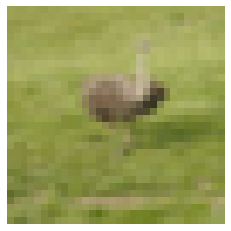

In [ ]:
import random

i = random.randint(0, len(test_images))

img = test_images[i]
img_tensor = image.img_to_array(img)
img_tensor = np.expand_dims(img_tensor, axis=0)

class_names = ['airplane'
,'automobile'
,'bird'
,'cat'
,'deer'
,'dog'
,'frog' 
,'horse'
,'ship'
,'truck']

plt.imshow(img, cmap='viridis')
plt.axis('off')
plt.show()

In [ ]:
# Extracts the outputs of the top 8 layers:
layer_outputs = [layer.output for layer in model.layers[:8]]
# Creates a model that will return these outputs, given the model input:
activation_model = models.Model(inputs=model.input, outputs=layer_outputs)

In [ ]:
activations = activation_model.predict(img_tensor)
len(activations)
#There are two ways to instantiate a Model:With the "Functional API", where you start from Input, you chain layer calls to specify the model's forward pass, and finally you create your model from inputs and outputs:

7

In [ ]:
test_labels[i]

array([2], dtype=uint8)

In [ ]:
layer_names = []
for layer in model.layers:
    layer_names.append(layer.name)
    
layer_names

['conv2d',
 'max_pooling2d',
 'conv2d_1',
 'max_pooling2d_1',
 'flatten',
 'dense_3',
 'dense_4']

In [ ]:
activations[0].shape

(1, 30, 30, 128)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in true_divide


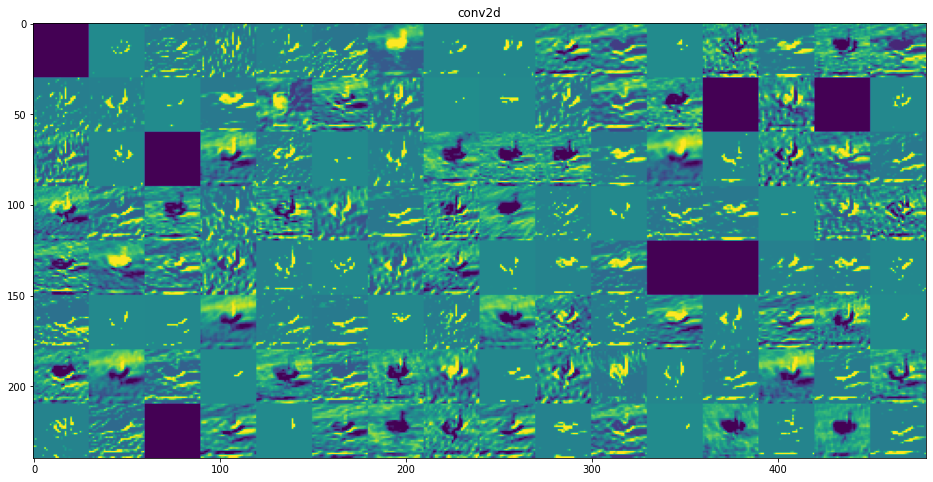

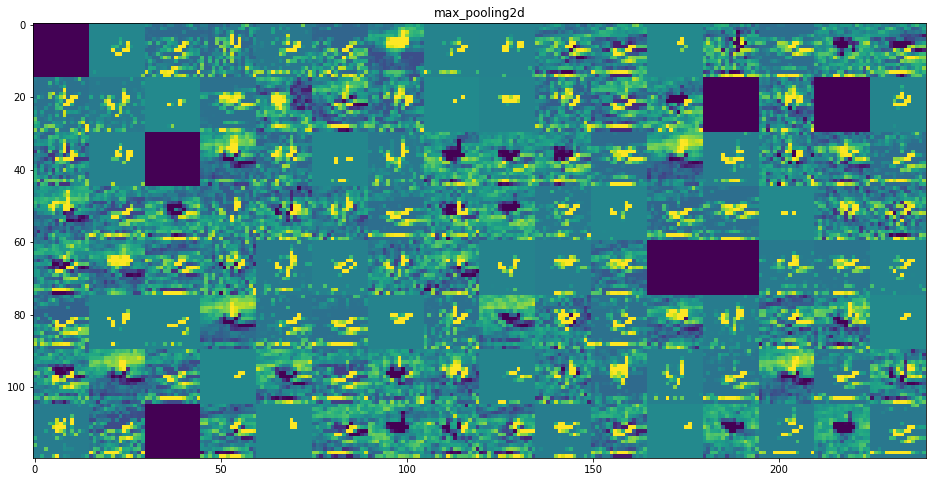

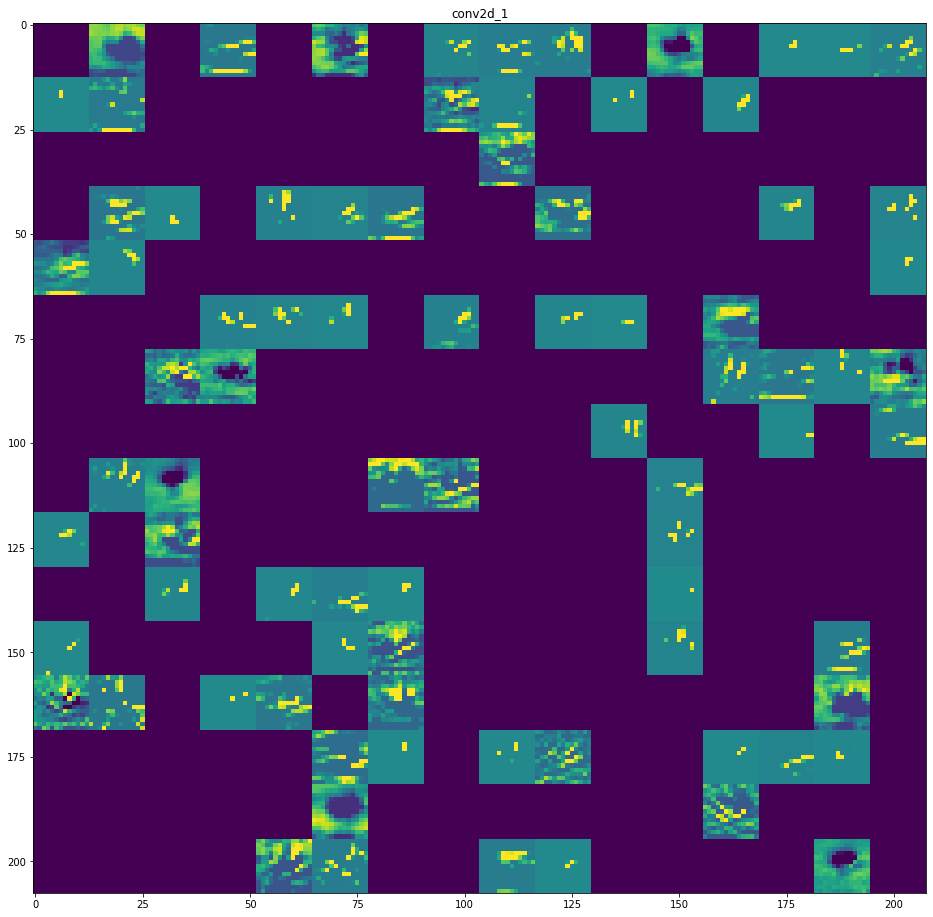

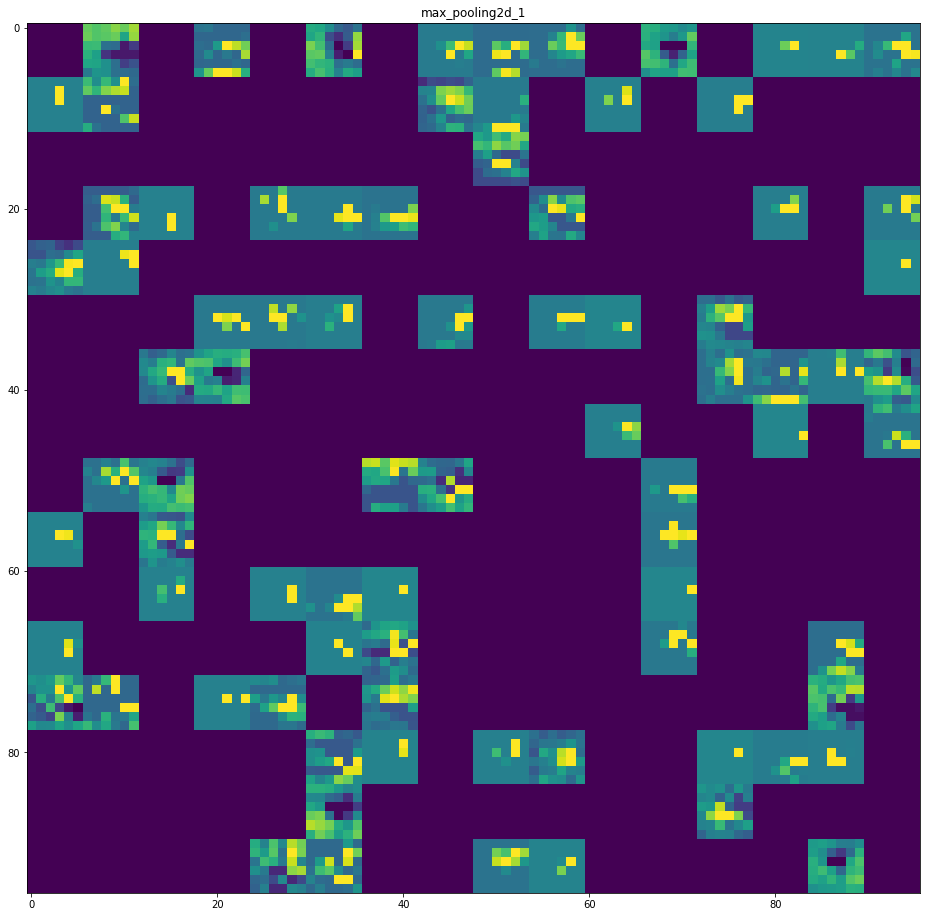

In [ ]:
layer_names = []
for layer in model.layers[:4]:
    layer_names.append(layer.name)

images_per_row = 16

# Now let's display our feature maps
for layer_name, layer_activation in zip(layer_names, activations):
    # This is the number of features in the feature map -> which is number of filters
    n_features = layer_activation.shape[-1]

    # The feature map has shape (1, size, size, n_features), which is width and height
    size = layer_activation.shape[1]

    # We will tile the activation channels in this matrix
    n_cols = n_features // images_per_row
    display_grid = np.zeros((size * n_cols, images_per_row * size))

    # We'll tile each filter into this big horizontal grid
    for col in range(n_cols):
        for row in range(images_per_row):
            channel_image = layer_activation[0,
                                             :, :,
                                             col * images_per_row + row]
            # Post-process the feature to make it visually palatable
            channel_image -= channel_image.mean()
            channel_image /= channel_image.std()
            channel_image *= 64
            channel_image += 128
            channel_image = np.clip(channel_image, 0, 255).astype('uint8')
            display_grid[col * size : (col + 1) * size,
                         row * size : (row + 1) * size] = channel_image

    # Display the grid
    scale = 1. / size
    plt.figure(figsize=(scale * display_grid.shape[1],
                        scale * display_grid.shape[0]))
    plt.title(layer_name)
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto', cmap='viridis')
    
plt.show();

In [ ]:
%%shell
jupyter nbconvert --to html /content/gdrive/MyDrive/MSDS458/Liu_Assignment2_MSDS458_3.ipynb

[NbConvertApp] Converting notebook /content/gdrive/MyDrive/MSDS458/Liu_Assignment2_MSDS458_3.ipynb to html
[NbConvertApp] Writing 1321676 bytes to /content/gdrive/MyDrive/MSDS458/Liu_Assignment2_MSDS458_3.html
